In [661]:
import pickle

In [663]:
import pickle

with open('masks_dataset.pickle', 'rb') as f:
    data = pickle.load(f)

In [665]:
print(type(data))
print(len(data))


<class 'tuple'>
2


In [667]:
images, labels = data

print(f"Images type: {type(images)}")
print(f"Labels type: {type(labels)}")   
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")                  


Images type: <class 'numpy.ndarray'>
Labels type: <class 'numpy.ndarray'>
Images shape: (355, 32, 32, 3)
Labels shape: (355,)


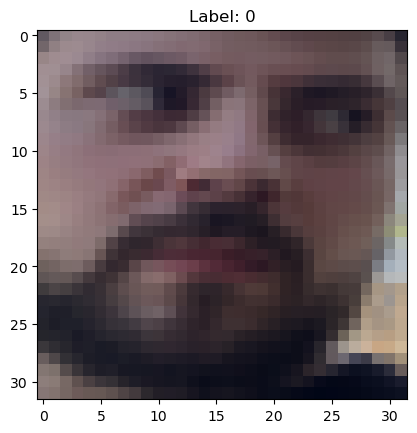

In [671]:
import matplotlib.pyplot as plt
plt.imshow(images[0])  
plt.title(f"Label: {labels[0]}")
plt.show()

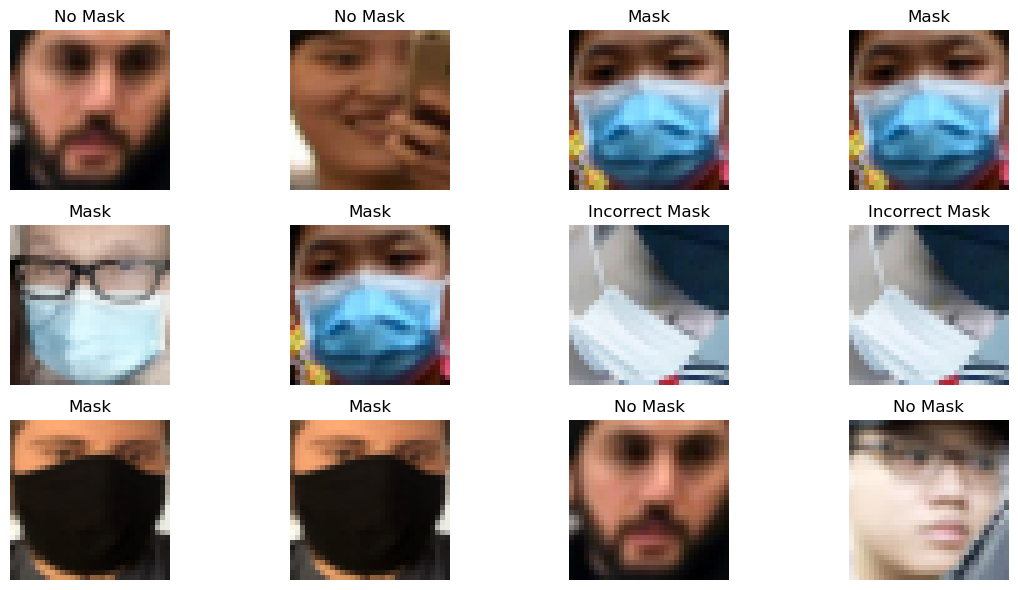

In [990]:
import matplotlib.pyplot as plt
import numpy as np
import random

label_names = {
    0: "No Mask",
    1: "Mask",
    2: "Incorrect Mask"
}

plt.figure(figsize=(12, 6))
for i in range(12):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    label = labels[idx]

    # Convert CHW to HWC if needed
    if img.ndim == 3 and img.shape[0] in [1, 3]:
        img = np.transpose(img, (1, 2, 0))

    # Normalize if image looks too dark
    img = (img - img.min()) / (img.max() - img.min())

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(label_names.get(label.item(), f"Label {label}"))
    plt.axis('off')

plt.tight_layout()
plt.show()


In [673]:
# Normalize the images to the range [0, 1]
images = images.astype(np.float32) / 255.0 

# Check the data after normalization
print(f"Normalized Images shape: {images.shape}")

# check the type of labels
print(f"Labels unique values: {np.unique(labels)}")

Normalized Images shape: (355, 32, 32, 3)
Labels unique values: [0 1 2]


In [675]:
from sklearn.model_selection import train_test_split
import torch

# Split the dataset into 80% train and 20% validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert the NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2)  # (batch_size, channels, height, width)
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2)  # Same transformation for validation data

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)

# Verify the shapes of the tensors
print(f"Training set shape: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation set shape: {X_val_tensor.shape}, {y_val_tensor.shape}")


Training set shape: torch.Size([284, 3, 32, 32]), torch.Size([284])
Validation set shape: torch.Size([71, 3, 32, 32]), torch.Size([71])


In [677]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader objects
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify that the DataLoader is working
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}, Batch of labels shape: {labels.shape}")
    break


Batch of images shape: torch.Size([32, 3, 32, 32]), Batch of labels shape: torch.Size([32])


In [898]:
import torch.nn as nn
import torch.nn.functional as F  

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.7)
        
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(64, 28)
        self.bn3 = nn.BatchNorm1d(28)
        self.dropout3 = nn.Dropout(0.7)
        
        
        self.fc4 = nn.Linear(28, 3)
        
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x



# Instantiate the model
model = SimpleNN()

# Print the model architecture
print(model)


SimpleNN(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.7, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=64, out_features=28, bias=True)
  (bn3): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.7, inplace=False)
  (fc4): Linear(in_features=28, out_features=3, bias=True)
)


In [900]:
import torch.optim as optim
import torch.nn.functional as F

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer (Adam)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=10e-5) # 0.001
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=10e-2, momentum=0.9)

# Check if everything is working fine
print("Loss function and optimizer set up successfully.")


Loss function and optimizer set up successfully.


In [902]:
# Number of epochs (iterations over the entire dataset)
num_epochs = 1000

# Lists to store loss and accuracy values for visualization later
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Iterate over the training data
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = loss_fn(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class labels
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # Calculate the average loss and accuracy for this epoch
    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store the loss and accuracy for training
    train_losses.append(avg_loss)
    train_accs.append(accuracy)
    
    # Now, evaluate on the validation set (outside the inner training loop)
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    # No gradient tracking for validation
    with torch.no_grad():
        # Iterate over the validation data
        for images, labels in val_loader:
            outputs = model(images)
            val_loss = loss_fn(outputs, labels)
            
            # Track validation loss and accuracy
            running_val_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)

    # Calculate the average validation loss and accuracy
    avg_val_loss = running_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Store the loss and accuracy for validation
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

print("Training complete.")


Epoch [1/1000], Training Loss: 1.2995, Training Accuracy: 37.32%, Validation Loss: 1.0979, Validation Accuracy: 45.07%
Epoch [2/1000], Training Loss: 1.2162, Training Accuracy: 39.08%, Validation Loss: 1.0910, Validation Accuracy: 45.07%
Epoch [3/1000], Training Loss: 1.1631, Training Accuracy: 40.85%, Validation Loss: 1.0812, Validation Accuracy: 45.07%
Epoch [4/1000], Training Loss: 1.1099, Training Accuracy: 42.61%, Validation Loss: 1.0738, Validation Accuracy: 45.07%
Epoch [5/1000], Training Loss: 1.1068, Training Accuracy: 43.31%, Validation Loss: 1.0697, Validation Accuracy: 45.07%
Epoch [6/1000], Training Loss: 1.0792, Training Accuracy: 47.54%, Validation Loss: 1.0603, Validation Accuracy: 45.07%
Epoch [7/1000], Training Loss: 1.0843, Training Accuracy: 45.07%, Validation Loss: 1.0515, Validation Accuracy: 45.07%
Epoch [8/1000], Training Loss: 1.0682, Training Accuracy: 42.61%, Validation Loss: 1.0440, Validation Accuracy: 45.07%
Epoch [9/1000], Training Loss: 1.0630, Training 

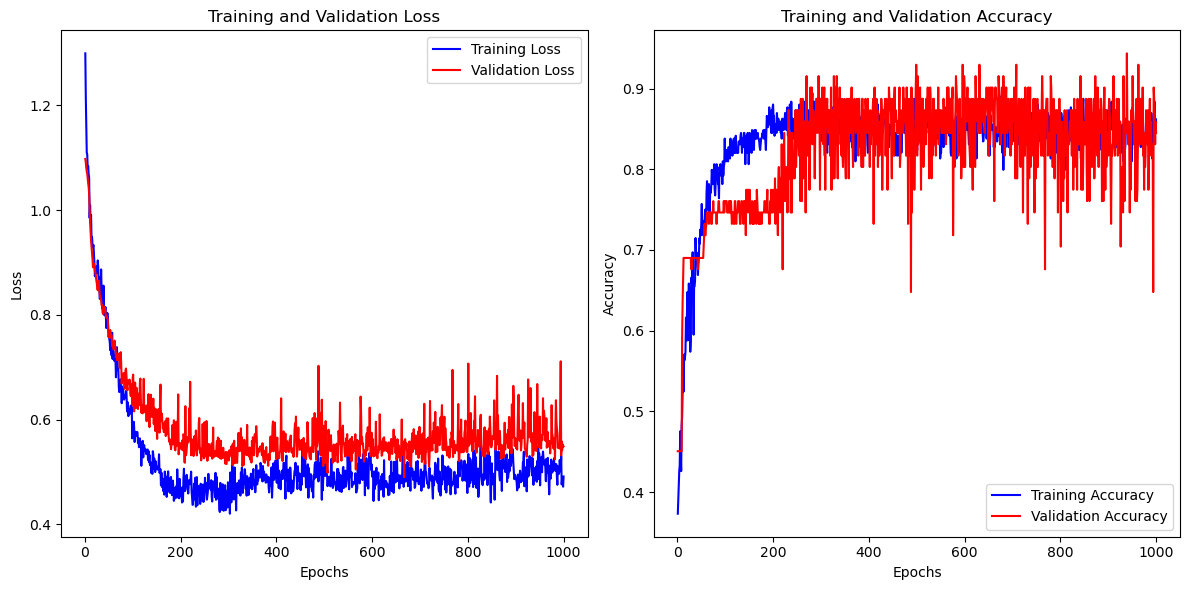

In [904]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [929]:
import torch

def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [935]:
evaluate_model(model, val_loader)

Validation Accuracy: 84.51%


0.8450704225352113

In [1016]:
def plot_incorrect_predictions(model, val_loader, num_images=12):
    model.eval()

    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Identify incorrect predictions
            incorrect_indices = (predicted != labels)
            incorrect_images.extend(images[incorrect_indices])
            incorrect_labels.extend(labels[incorrect_indices].cpu().numpy())
            incorrect_preds.extend(predicted[incorrect_indices].cpu().numpy())

    print(len(incorrect_labels))

    # Randomly select indices from incorrect predictions
    total_incorrect = len(incorrect_images)
    if total_incorrect == 0:
        print("No incorrect predictions to display.")
        return

    selected_indices = random.sample(range(total_incorrect), min(num_images, total_incorrect))

    # Plot the selected incorrect images
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(selected_indices):
        img = incorrect_images[idx].cpu().numpy().transpose(1, 2, 0) * 255.0
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {incorrect_labels[idx]}, Pred: {incorrect_preds[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

11


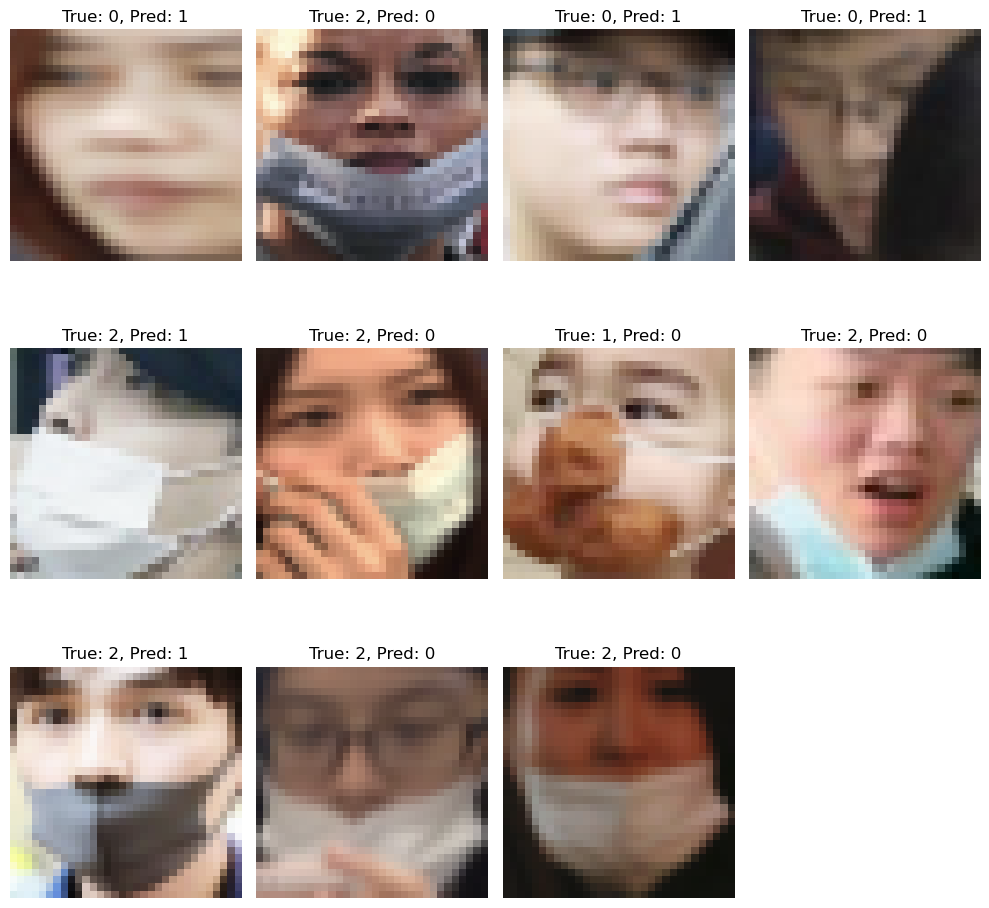

In [1018]:
plot_incorrect_predictions(model, val_loader)

7


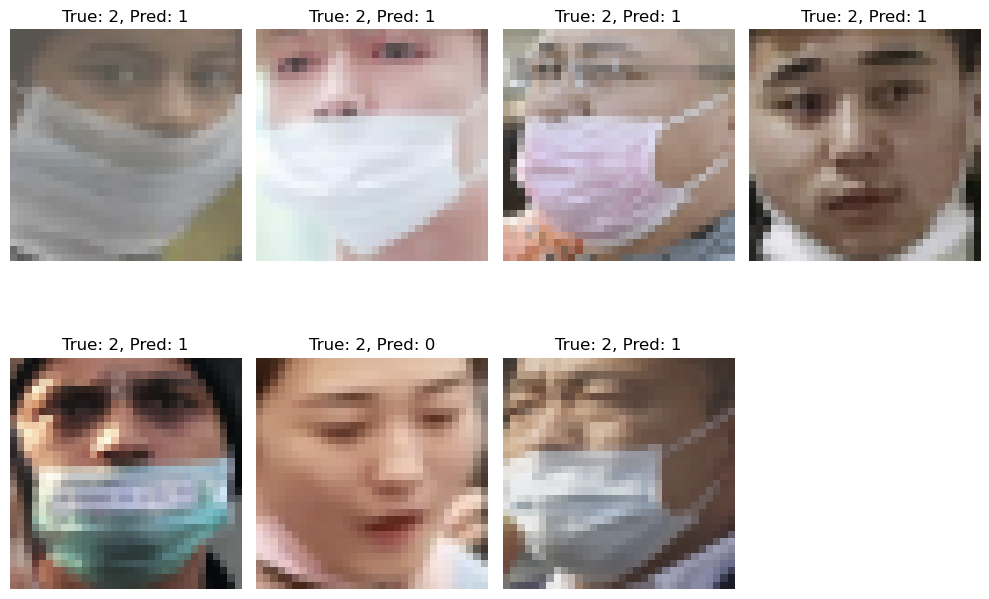

In [1020]:
plot_incorrect_predictions(model, train_loader)

In [1022]:
# Save the model
torch.save(model.state_dict(), "mask_detector.pth")
